# Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**First**, you need to **load your google drive**.

By default, your root path is on temperal device and your data will be cleaned once you disconnect with the google device.

Google drive is recommened, or you need to download what you need manually.

**And, switch to the GPU mode!**
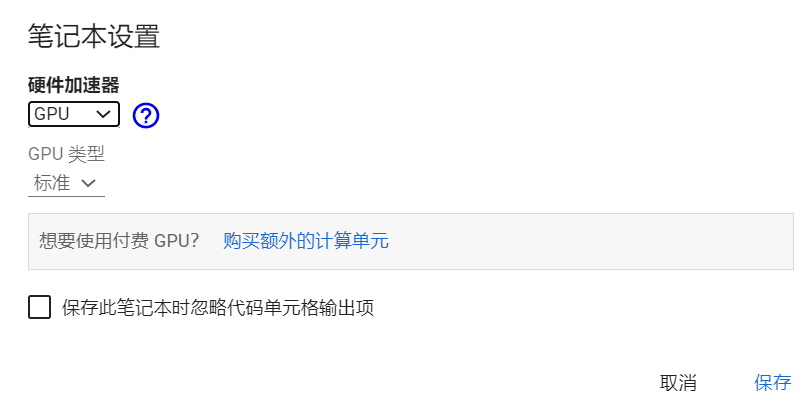

**Second, switch to your project root path:**

In [2]:
%cd '/content/drive/MyDrive/5018Project_MCTACO/' 

/content/drive/MyDrive/5018Project_MCTACO


## Packages Installation

In [3]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00


In [5]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


## Import

In [6]:
# numpy
import numpy as np

# pandas
import pandas as pd

# torch
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

# random
import random

# json
import json

# os
import os

# transformers(hugging face)
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers.trainer_pt_utils import get_parameter_names
from transformers.optimization import Adafactor, get_scheduler

# sklearn
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle as sk_shuffle

# tqdm
from tqdm import tqdm

# warnings
import warnings
warnings.filterwarnings("ignore")   # mute all the warnings

# csv
import csv

# Settings

In [44]:
settings={
    'model_name':'microsoft/deberta-v3-large',
    'dataset':'MCTACO',

    'continue':False,
    'checkpoint':'./checkpoint/',
    'from_pretrained':'deberta-v3-large_best', # model path under dir checkpoint 

    'num_choices':2,
    'weight_decay':0.0,
    'adam_epsilon':1e-8,
    'learning_rate':3e-6,
    'epochs':5,
    'eval_batch_size':8,
    'train_batch_size':8,
    'shuffle':False,
}

# Models
Reference/ Official document:

[AutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification)

[AutoModelForSequenceClassification](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification)

## RoBERTa

[RoBERTA Hugging Face Reference](https://huggingface.co/transformers/v3.0.2/model_doc/roberta.html#transformers.RobertaForSequenceClassification)

In [8]:
class RoBERTa(nn.Module):
    def __init__(
        self,
        name: str,      # model name
        num_choices: int,   # output dimensions
        settings
    ):
        super().__init__()
        
        self.name = name
        self.num_choices = num_choices
        self.max_length = 512

        # initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True)

        # initialize model
        if settings['continue']:
            path = settings['checkpoint']+settings['from_pretrained']
            print("Loading from pretrained...")
            self.model = AutoModelForSequenceClassification.from_pretrained(path)
        else:
            print("Loading new model...")
            self.model = AutoModelForSequenceClassification.from_pretrained(name)
        
        # loss function
        self.ce_loss_func = nn.CrossEntropyLoss() # input:(batch_size, num_of_class)

    def save_pretrained(self, path):
        """
        desc:
            save trained model to self-defined path
        """
        self.model.save_pretrained(path, from_pt=True)
        print(f"model saved at {path}")
        
    def score_input(self, content):
        """
        desc:
            feed content to the language model
            return the logits
        """
        batch = self.tokenizer(
            content, padding=True, truncation=True, max_length=self.max_length, return_tensors="pt"
        )
        out = self.model(
            batch["input_ids"].to(self.model.device), batch["attention_mask"].to(self.model.device),
            output_hidden_states=True
        )
        return out["logits"]

    def forward(self, batch):
        """
        desc:
        return:
            preds       unclear so far, considering to remove
            preds_cls     predicted class, for batch size=8, return predicted label list [1,0,1...] len = 8
            loss
        """
        content, labels  = batch
        logits = self.score_input(content)
        labels = torch.tensor(labels, dtype=torch.long).to(logits.device)
        loss = self.ce_loss_func(logits, labels)
        preds_cls = list(torch.argmax(logits, 1).cpu().numpy())
        
        preds = None
        return loss, preds, preds_cls

# Dataset

In [9]:
class CommonsenseQADataset(Dataset):
    def __init__(self, f, sep_token, input_format, shuffle):
        content, labels = [], []
        x = open(f).readlines()
        if shuffle:
            random.shuffle(x)
        
        for line in x:
            instance = json.loads(line)
            question = instance["question"]["stem"]
            choices = [item["text"] for item in instance["question"]["choices"]]
            if "answerKey" in instance:
                l = instance["answerKey"]
            else:
                l = "A"
            
            if input_format == "0":
                for c in choices:
                    content.append("{} {}".format(question, c))
            elif input_format == "1":
                for c in choices:
                    content.append("{} \\n {}".format(question, c))
            
            if l == "A":
                labels += [1, 0, 0, 0, 0]
            elif l == "B":
                labels += [0, 1, 0, 0, 0]
            elif l == "C":
                labels += [0, 0, 1, 0, 0]
            elif l == "D":
                labels += [0, 0, 0, 1, 0]
            elif l == "E":
                labels += [0, 0, 0, 0, 1]
                
        self.content, self.labels = content, labels
        
    def __len__(self):
        return len(self.content)

    def __getitem__(self, index):
        s1, s2 = self.content[index], self.labels[index]
        return s1, s2
    
    def collate_fn(self, data):
        dat = pd.DataFrame(data)
        return [dat[i].tolist() for i in dat]

## MCTACO

In [10]:
class MCTACODataset(Dataset):
    def __init__(self, f, sep_token, input_format, shuffle):
        content, labels = [], []
        with open(f, 'r') as file:
            x = csv.reader(file, dialect='excel', delimiter='\t')

            if shuffle:
                random.shuffle(x)
            
            for line in x:
                context, question, candidate = line[0], line[1], line[2]
                if input_format == "0":
                    content.append("{} {} {}".format(context, question, candidate))
                else:
                    content.append("{} {}".format(question, candidate))

                if line[3] == "yes":
                    labels += [1]
                else:
                    labels += [0]
                
        self.content, self.labels = content, labels
        
    def __len__(self):
        return len(self.content)

    def __getitem__(self, index):
        s1, s2 = self.content[index], self.labels[index]
        return s1, s2
    
    def collate_fn(self, data):
        dat = pd.DataFrame(data)
        return [dat[i].tolist() for i in dat]

## dataloader function

In [11]:
def configure_dataloaders(sep_token, train_batch_size=settings['train_batch_size'], eval_batch_size=settings['eval_batch_size'], shuffle=False, input_format="0"):
    "Prepare dataloaders"
    dev_dataset = MCTACODataset("./data/MCTACO/dev_3783.tsv", sep_token, input_format, False)
    dev_loader = DataLoader(dev_dataset, shuffle=False, batch_size=train_batch_size)
    
    test_dataset = MCTACODataset("./data/MCTACO/test_9442.tsv", sep_token, input_format, False)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=eval_batch_size)

    return dev_loader, test_loader

# Training

## optimizer

In [12]:
def configure_optimizer(model, settings):
    """
    desc:
        Prepare optimizer and schedule (linear warmup and decay)
    """
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": settings['weight_decay'],
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]

    # Initialize optimizer: AdamW by default
    optimizer = AdamW(
        optimizer_grouped_parameters, 
        lr=settings['learning_rate'], 
        eps=settings['adam_epsilon']
        )
    return optimizer

## train for one epoch

In [13]:
def train_or_eval_model(model, dataloader, optimizer=None, split="Train"):
    """
    desc:
        function for execute train/validation/test in one epoch

    """
    losses, preds_cls, labels_cls,  = [], [], []
    if split=="Train":
        model.train()
    else:
        model.eval()
    
    for batch in tqdm(dataloader, leave=False):
        content, l_cls = batch
        loss, _, p_cls = model(batch)
        
        preds_cls.append(p_cls)
        labels_cls.append(l_cls)
        
        if split=="Train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        losses.append(loss.item())

    avg_loss = round(np.mean(losses), 4)
    

    all_preds_cls = [item for sublist in preds_cls for item in sublist]
    all_labels_cls = [item for sublist in labels_cls for item in sublist]
    acc = round(accuracy_score(all_labels_cls, all_preds_cls), 4)

    return avg_loss, acc, all_preds_cls, all_labels_cls

## main

In [45]:
# Initialize model

model = RoBERTa(
    name = settings['model_name'],
    num_choices=settings['num_choices'],
    settings = settings
).cuda()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading new model...


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [46]:
sep_token = model.tokenizer.sep_token

# Initialize optimizer
optimizer = configure_optimizer(model, settings)

epochs  = settings['epochs']

preds = None
best_acc = 0

for e in range(epochs):
    dev_loader, test_loader = configure_dataloaders(sep_token)

    train_avg_loss, train_acc, _, _ = train_or_eval_model(model, dev_loader, optimizer, split="Train")
    test_avg_loss, test_acc, all_preds_cls, all_labels_cls = train_or_eval_model(model, test_loader, split="Test")

    if test_acc > best_acc:
        best_acc = test_acc
        preds = ['yes' if x == 1 else 'no' for x in all_preds_cls]

    print(f"epoch:{e+1}, train loss:{train_avg_loss}, train acc:{train_acc}")
    print(f"test loss:{test_avg_loss}, test acc:{test_acc}")

epoch:1, train loss:0.4737, train acc:0.7552
test loss:0.3239, test acc:0.8738


epoch:2, train loss:0.2199, train acc:0.9202
test loss:0.3127, test acc:0.8793


epoch:3, train loss:0.1122, train acc:0.959
test loss:0.3805, test acc:0.8735


epoch:4, train loss:0.0624, train acc:0.9799
test loss:0.3718, test acc:0.8909


epoch:5, train loss:0.0446, train acc:0.9878
test loss:0.4523, test acc:0.883


## save

In [47]:
with open(f"./result/{settings['from_pretrained']}_frompretrained_{settings['continue']}.txt", 'w') as f:
    for line in preds:
        f.write(f"{line}\n")

# 新段落

In [ ]:
model.save_pretrained(settings['checkpoint'] + f"{settings['model_name']}_best")

model saved at ./checkpoint/roberta-large_best
